## Learning Goal

The goal of this notebook is to familiarize the reader with the powerful package XGBoost for constructing gradient boosted trees. We will discuss how to visualize feature importances as well as techniques for optimizing XGBoost.

## Overview

In this notebook, we will focus on using Gradient Boosted Trees (in particular XGBoost) to classify the supersymmetry (SUSY) dataset, first introduced by [Baldi et al. Nature Communication 2015 and Arxiv:1402.4735](https://arxiv.org/pdf/1402.4735.pdf]). 
The supersymmetry data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with 18 features. The signal process is the production of electrically-charged supersymmetric particles which decay to W bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first 8 features are "raw" (low-level) kinematic features that can be directly measured from collisions. The final 10 features are "hand constructed" (high-level) features that have been chosen using physical knowledge, and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

We will drawn upon the useful blog posts that compactly introduces many of the basics of hyperparameter tuning. As we will see, there are many practical trade-offs we have to worry about. Unlike Random Forests, for more complicated algorithms such as XGBoost, overfitting can be a major worry. It is also extremely computationally expensive to do hyperparameter searches. However, this notebook should get you started on these interesting methods.

## Downloading the SUSY dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz. The dataset is quite large. Download the dataset and unzip it in a directory. We will be using this dataset with gradient boosted trees. We will focus on the XGBoost aglorithm.


### Description of Data 

From https://archive.ics.uci.edu/ml/datasets/SUSY:  the following image displays the signal (a) vs the background (b): the signal involves an hypotethical supersymmetric particle $\chi^{\pm}$ and $\chi^{0}$ (undetected) along with charged leptons $l^{\pm}$ and neutrinos $\nu$. 
The background process involves $W$ bosons decaying in leptons $l^{\pm}$ and neutrinos $\nu$. In both cases, the resulting observed particles are two charged leptons, since neutrinos and $\chi^{0}$ escape undetected.

![signal (a) VS background (b)](SUSY.png)

The classification task requires distinguishing between these two processes and the missing transverse momentum. Simulated events are generated with MADGRAPH event generator assuming 8 TeV collisions of protons at LHC, with showering and hadronization performed by PYTHIA and detector response simulated by DELPHES. 
Notice the masses are set to $m_{\chi^{\pm}}=$ 200 GeV and $m_{\chi^{0}}$ = 100 GeV. 
We focus on fully leptonic decay mode of $W$ bosons, both into $l\nu$ (final state $l\nu l\nu$).

We consider events which satisfy the requirements:
- exactly two electrons or muons each with $p_{\perp}>$ 20 GeV and $|\eta|<$ 2.5
- at least 20 GeV of missing transverse mass 

The basic detector response is used to measure the momentum of each visible particle, basically leptoons, though there may be particle jets induced by radiative processes. 
A critical quantity if the missing transverse momentum $E_{T}$. 

High-level features to select signal vs background (cannot have invariant mass here due to undetected particles):

- **axial $E_{T}$**: missing transverse energy along the vector defined by the charged leptons 

- **transverse mass M_{T2}**: estimating the mass of particles produced in pairs and decaying semi-invisibly [17,18]

- **$E_{T}^{Rel}$**: $E_{T}$ if $\Delta \phi \leq \pi /2$,  $E_{T} \sin{(\Delta\phi)}$ if $\Delta \phi < \pi /2$, where $\Delta\phi$ is the minimum angle between $E_{T}$ and a jet or lepton 

- **razor quantities: $\beta, R$ and $M_{R}$** [19]

- **super-razor quantities $\beta_{R+1}, \cos{(\theta_{R+1}), \Delta\Phi_{R}^{\beta}}, M_{\Delta}^{R}, M_{R}^{T}$ and $\sqrt{\hat{s}_{R}}$** [20]


<br />
<br />



See https://arxiv.org/pdf/1402.4735.pdf 

</br> References: </br>

[1] Cheng, H.-C. & Han, Z. Minimal Kinematic Constraints and m(T2). JHEP 0812, 063 (2008).

[2] Barr, A., Lester, C. & Stephens, P. m(T2): The Truth behind the glamour. J. Phys. G29, 2343–2363 (2003).

[3] Rogan, C. Kinematical variables towards new dynamics at the LHC (2010).

[4] Buckley, M. R., Lykken, J. D., Rogan, C. & Spiropulu, M. Super-Razor and Searches for Sleptons and Charginos at the LHC (2013).



## Installing XGBoost

If you have not already done so, you will also have to install the XGBoost python package, see e.g. https://github.com/dmlc/xgboost/tree/master/python-package. The easiest way to do this is to clone the Github repository, navigate to this directory, and use the pip command: pip install xgboost. Alternatively, one can use Anaconda: conda install -c conda-forge xgboost.

Size of dataset : 100000


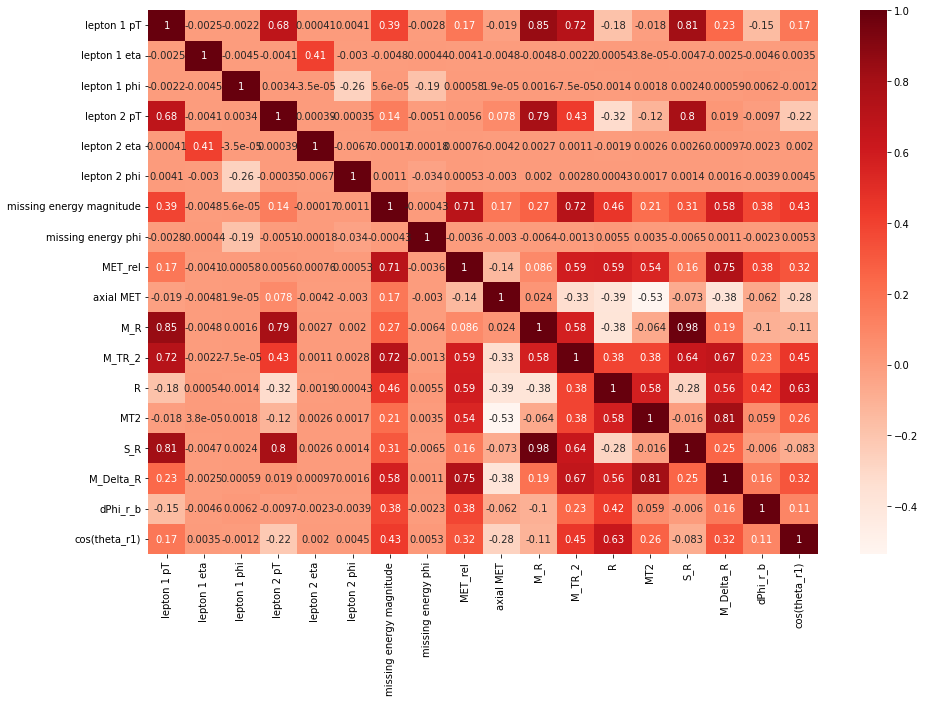

In [3]:
#Load the dataset using pandas and numpy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib as mpl
#mpl.rcParams.update(style.style)
import matplotlib.pyplot as plt
import seaborn as sns

#Filename [CHANGE THIS TO YOUR FILENAME FOR SUSY]
filename='/Users/cfanelli/Desktop/ML4HEP/data/SUSY.csv'

#Read in SUSY File. We will only work with subset of data for demonstration purposes.

features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
 'missing energy magnitude', 'missing energy phi']

high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

#Number of datapoints to work with
N = 100000
print("Size of dataset : %i"%N)
df = pd.read_csv(filename, header=None,nrows=N,engine='python')
df.columns=features

subset_feat = features #change to low_features if you want to train on low_features
sub_df = df[subset_feat]

sub_df.head()

y = sub_df['SUSY'].values
X = sub_df[[col for col in sub_df.columns if col!="SUSY"]]

plt.rcParams["figure.figsize"] = (15,10)
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Training

In [4]:

#Make datasets using only the 8 low-level features and 10 high-level features
#X_low=X[low_features]
#X_high=X[high_features]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)
#X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y, test_size=.1, random_state=0)
#X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y, test_size=.1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)



## Training 

In [5]:
# Training Phase

from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


model = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000, use_label_encoder=False, eval_metric='logloss')

start_time = time.time()
model.fit(X_train, y_train)
run_time = time.time() - start_time

print("Done training. Runtime: {:.2f} sec\n".format(run_time))

Done training. Runtime: 69.69 sec



In [6]:
# Make Predictions

y_pred= model.predict(X_test)

#Print Results
print("Model Accuracy with all features is: {:.2f}%".format(100*model.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))

# Compare the same with the total sample (i.e. ~training dataset)
y_all= model.predict(X)

#Print Results
print("Model Accuracy with all features over the entire dataset is: {:.2f}%".format(100*model.score(X, y)))
print("The AUC score with all features  over the entire dataset is {:.2f}".format(roc_auc_score(y,y_all)))




Model Accuracy with all features is: 77.71%
The AUC score with all features is 0.77
Run time with all features: 69.69 sec


Model Accuracy with all features over the entire dataset is: 95.81%
The AUC score with all features  over the entire dataset is 0.96


## Visualization 

0.05
0.1


,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
99995,0.890226,0.813879,-1.444316,0.677243,-0.703586,0.635831,2.952594,1.615619,3.029709,3.096050,0.940098,1.160114,1.095078,0.000000,1.025253,1.637652,1.496974,0.163885
99996,0.753242,1.078643,1.012611,0.918261,0.450237,-0.630174,0.588488,-0.175550,0.640745,0.200901,0.724957,0.707737,0.866319,0.000000,0.742235,0.384781,1.244281,0.207361
99997,0.792020,0.009340,-1.379194,1.016544,-1.444512,0.587220,0.638068,-0.880799,0.376837,0.242691,1.029068,0.761515,0.656673,0.855276,1.039521,0.686952,1.133271,0.060323
99998,0.514347,-1.141402,-0.445579,0.813701,-0.293823,0.554818,0.540604,1.676716,0.811514,-0.218496,0.588465,0.741077,1.117527,1.417454,0.588163,1.055959,0.736099,0.067626
99999,0.417832,1.089810,0.271299,0.498958,0.833847,1.658956,0.522072,-1.147172,0.726959,-0.196093,0.377339,0.562619,1.323116,0.728193,0.414179,0.570315,1.477853,0.333969


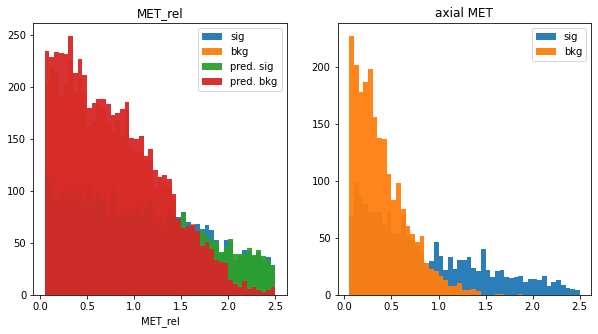

In [14]:
#https://www.thphys.uni-heidelberg.de/~gk_ppbsm/lib/exe/fetch.php?media=students:lectures:rtgneuralnetworks_lecture1.2_antel.pdf

#------------------------------------------#
# truth-matched dataframes with no selection 
#------------------------------------------#

#low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
# 'missing energy magnitude', 'missing energy phi']

#high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


sel_feature1 = "MET_rel"  
sel_feature2 = "axial MET"

# filter HIGGS data (signal)  
sig_X = X_test[y_test==1] 

# filter HIGGS data (bkgd) 
bkg_X = X_test[y_test==0] 

#------------------------------------------#
# truth-matched dataframes after selection 
#------------------------------------------#

y_pred_test= model.predict(X_test)
# filter HIGGS data (signal)  
sig_X_pred = X_test[y_pred_test==1] 

# filter HIGGS data (bkgd) 
bkg_X_pred = X_test[y_pred_test==0] 


#------------------------------------------#
#                 PLOTS
#------------------------------------------#

#plt.rcParams["figure.figsize"] = (10,6)


column1 = X_test[sel_feature1]
max_value1 = 2.500 #column1. max() 
min_value1 = 0.050#column1. min() 
#max_value = column. max() 
#min_value = column. min() 


bins1 = np.linspace(min_value1, max_value1, 50) 
#bins =50


plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
n_S1, bins_S1, patches_S1 = plt.hist(sig_X[sel_feature1], bins1, alpha=0.95, label='sig')
n_B1, bins_B1, patches_B1 = plt.hist(bkg_X[sel_feature1], bins1, alpha=0.95, label='bkg')
n_S1_pr, bins_S1_pr, patches_S1_pr = plt.hist(sig_X_pred[sel_feature1], bins1, alpha=0.95, label='pred. sig')
# n_B1_pr, bins_B1_pr, patches_B1_pr = plt.hist(bkg_X_pred[sel_feature1], bins1, alpha=0.95, label='pred. bkg')
# the individual patches used to create the histogram, e.g a collection of rectangles
plt.legend(loc='upper right',prop={'size': 10})
plt.title(sel_feature1)
plt.xlabel(sel_feature1)
#plt.show()

plt.subplot(1, 2, 2)
n_S2, bins_S2, patches_S2 = plt.hist(sig_X[sel_feature2], bins1, alpha=0.95, label='sig')
n_B2, bins_B2, patches_B2 = plt.hist(bkg_X[sel_feature2], bins1, alpha=0.95, label='bkg')
plt.legend(loc='upper right',prop={'size': 10})
plt.title(sel_feature2)
#plt.show()

mode_index1 = np.argmax(n_S1,axis=0) #0 finds column indices
mode1 = bins_S1[mode_index1]
print(mode1)

mode_index2 = np.argmax(n_S2,axis=0) #0 finds column indices
mode2 = bins_S2[mode_index2]
print(mode2)

X.head()
X.tail()

## Feature Importance

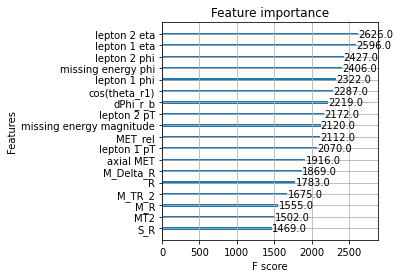

In [15]:
#magic function to render figure in a notebook 
%matplotlib inline

fig=plt.figure()
xgb.plot_importance(model, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #

# Importance as F score (https://en.wikipedia.org/wiki/F-score)

## ROC curve

0.7718221015559942


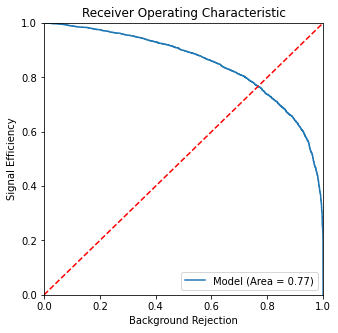

In [17]:
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, model.predict(X_test)) 
print(logit_roc_auc)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# Decreasing thresholds on the decision function used to compute fpr and tpr.
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1]) 
bkgd_rejection    = 1-fpr
signal_efficiency = tpr 

#print("shape of eff(S):", np.shape(signal_efficiency), ", shape of rej(B): ", np.shape(bkgd_rejection)


plt.figure(figsize=(5,5))
plt.plot(bkgd_rejection, signal_efficiency, label='Model (Area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Background Rejection') # background rejection 
plt.ylabel('Signal Efficiency')  # signal efficiency 
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./images/XGBoost_ROC_SUSY')
plt.show()

## Tune probability cut (output) to select point in the ROC curve

In [18]:
tmpy_pred = model.predict(X_test) 
tmpy_prob = model.predict_proba(X_test)[:,1] 

N = len(y_test)
threshold_value = 0.5   #you can tune this cut 

mask = [tmpy_prob>threshold_value]
anti_mask = np.invert(mask)

mask_true_sig  = [y_test==1]
mask_true_sig  = mask_true_sig[0].astype(int)
mask_true_bkgd = [y_test==0]
mask_true_bkgd = mask_true_bkgd[0].astype(int)


N_sig = mask_true_sig.sum()
N_bkgd = mask_true_bkgd.sum()

print("N: ", N, ", N_sig: ", N_sig, ", N_bkgd: ", N_bkgd)

anti_y_test = [not Elem for Elem in y_test]

true_sig    = np.logical_and(mask,y_test) #element wise
true_bkgd   = np.logical_and(anti_mask,anti_y_test)

tmp_S_eff = true_sig.sum()/N_sig
tmp_B_rej = true_bkgd.sum()/N_bkgd

print("\n\n*******************************************")
print("          sig. efficiency: {:.3f}".format(tmp_S_eff))
print("          bkgd. rejection: {:.3f}".format(tmp_B_rej))
print("*******************************************\n\n")

# Let's retrieve this from the calculated ROC curve 

# find index of list closest to value 
a = thresholds
idx_found = min(range(len(a)), key=lambda i: abs(a[i]-threshold_value))

print("\n\n*******************************************")
print("          sig. efficiency: {:.3f}".format(signal_efficiency[idx_found]))
print("          bkgd. rejection: {:.3f}".format(bkgd_rejection[idx_found]))
print("          (index: {:d})".format(idx_found))
print("*******************************************\n\n")




N:  10000 , N_sig:  4598 , N_bkgd:  5402


*******************************************
          sig. efficiency: 0.706
          bkgd. rejection: 0.837
*******************************************




*******************************************
          sig. efficiency: 0.707
          bkgd. rejection: 0.837
          (index: 1234)
*******************************************




## Optimizing XGBoost

We will now optimize the parameters of the XGBoost algorithm by performing a grid search. We will use the very useful new function from scikit-learn **GridSearchCV()**. This function allows you <u>to specify lists of parameters to search over</u>.

Let us briefly discuss what parameters we can tune to improve performance with descriptions:

- **max_depth [default=6]**: maximum depth of a tree, increasing this value will make the model more complex / likely to overfit.
- **eta or 'learning_rate'[default =0.3]**: step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features. *eta* actually shrinks the feature weights to make the boosting process more conservative.
- **gamma or min-split-loss [default=0]**: This is the penalty that regularizes the number of leaves. The larger, the more conservative the algorithm will be.
- **min_child_weight [default=1]**: In linear regression mode, this simply corresponds to the minimum number of instances needed to be in each node (min  *Bj*
  in notation of manuscript). The larger, the more conservative the algorithm will be. More generally, it is the minimum sum of instance weight (Hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.

As you can see this cross-validation procedure is quite computationally expensive. With the parameters below, it takes somewhere between 2 and 5 minutes on a powerful laptop. In the cell below, we perform the search and examine the results in the subsequent results.

In [19]:
from sklearn.model_selection import GridSearchCV 

#Create values to search over
cv_params = {'max_depth': [3,4,6], 'min_child_weight': [1,3,5], 'learning_rate':[0.05,0.1]}
ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1, 
             'objective': 'binary:logistic', 'use_label_encoder': False}

# XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000, use_label_encoder=False, eval_metric='logloss')
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, \
                                 scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)

opt_XGBclassifier.fit(X_train, y_train)
opt_XGBclassifier.cv_results_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[11:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'mean_fit_time': array([29.3685802 , 29.380547  , 29.36653738, 43.53598971, 43.55938134,
        43.27597814, 73.57008686, 69.09309583, 68.07529182, 26.24885578,
        32.51927185, 32.79868197, 46.94490705, 44.03967276, 43.09260874,
        70.27363529, 59.33410778, 52.52392449]),
 'std_fit_time': array([0.02168546, 0.1265863 , 0.12713951, 0.33916727, 0.25651209,
        0.18987194, 2.19169301, 0.37689879, 0.56613389, 1.77088755,
        0.62923624, 0.06991174, 0.28113644, 0.88744464, 0.25851981,
        1.61376991, 5.17168076, 0.15523747]),
 'mean_score_time': array([0.03681593, 0.03920417, 0.03200502, 0.04601145, 0.04705505,
        0.04543304, 0.04020395, 0.04631662, 0.04646668, 0.03800869,
        0.04181018, 0.04380693, 0.0448648 , 0.04396796, 0.04705186,
        0.0377027 , 0.02930231, 0.02500854]),
 'std_score_time': array([0.00619998, 0.00674819, 0.010242  , 0.00765161, 0.01206952,
        0.01009092, 0.00882818, 0.00710334, 0.00973571, 0.0089932 ,
        0.00401794, 0.0070

In [20]:
#Print scores
print('The optimal score on training set is {:0.3f}'.format(opt_XGBclassifier.best_score_))

#Find optimal parameters

print('The optimal parameters for the classifier are:')
print(opt_XGBclassifier.best_params_)

#Fit performance on the test set
XGBclassifier_final=opt_XGBclassifier.best_estimator_
y_pred_final=XGBclassifier_final.predict(X_test)
print("Model Accuracy with optimal parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))
print("The  AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred_final)))

The optimal score on training set is 0.797
The optimal parameters for the classifier are:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5}
Model Accuracy with optimal parameters: 79.73%
The  AUC score is 0.79


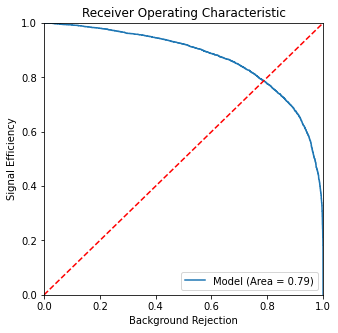

In [21]:
logit_roc_auc = roc_auc_score(y_test, XGBclassifier_final.predict(X_test)) 


fpr, tpr, thresholds = roc_curve(y_test, XGBclassifier_final.predict_proba(X_test)[:,1]) 
bkgd_rejection    = 1-fpr
signal_efficiency = tpr 

#print("shape of eff(S):", np.shape(signal_efficiency), ", shape of rej(B): ", np.shape(bkgd_rejection)


plt.figure(figsize=(5,5))
plt.plot(bkgd_rejection, signal_efficiency, label='Model (Area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Background Rejection') # background rejection 
plt.ylabel('Signal Efficiency')  # signal efficiency 
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./images/optimal_XGBoost_ROC_SUSY')
plt.show()